# Archive analysis

In [1]:
# Set root folder
import sys
import os

cwd = os.getcwd()
folder = os.path.basename(cwd)
cwd = os.path.dirname(cwd)
folder = os.path.basename(cwd)
ROOT = os.path.join(cwd)

sys.path.append(ROOT)

import numpy as np
from core.population import Archive
from environments.environments import *
from parameters import params
import pickle as pkl
import analysis.utils as utils
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import json
from scipy.stats.mstats import gmean


plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
font = {'size'   : 18}

plt.rc('font', **font)
%matplotlib inline

Root directory /home/giuseppe/src/cmans


### Get experiment data

In [2]:
env_type = 'arm'

if env_type == 'RW':
    env = 'Walker2D'
elif env_type == 'Dummy':
    env = 'Dummy'
elif env_type == 'CB':
    env = 'CollectBall'
elif env_type == 'AM':
    env = 'AntMaze'
elif env_type == 'arm':
    env = 'NDofArm'
elif env_type == 'maze':
    env = 'HardMaze'
elif env_type == 'cur':
    env = 'Curling'
elif env_type == 'cd':
    env = 'CurlingDense'

else:
    raise ValueError('Wrong environment type given: {}'.format(env_type))

# EXP_ROOT = '/mnt/7e0bad1b-406b-4582-b7a1-84327ae60fc4/cmans/'
    
exp_path = os.path.join(ROOT, 'experiment_data')
# exp_path = EXP_ROOT

exp_set_1 = ['STAX-P_multi', 'NS_all_gen', 'NSGA-II_all_gen', 'ME_all_gen', 'TAXONS_std', 'FitNS_all_gen']
# The rotate one is used for the maze, so I can easily flip the whole image to have the correct coord
exp_set_1_rot = ['FitNS_all_gen', 'TAXONS_std','ME_all_gen','NSGA-II_all_gen','NS_all_gen','STAX-P_multi']

exp_set_2 = ['STAX-P_multi', 'STAX-P_single', 'STAX_multi', 'STAX_single']
exp_set_3 = ['STAX-P_multi', 'STAX-P_multi_reset', 'STAX-NT_multi', 'STAX-NT_multi_reset']

CB = ['SIGN_sign5', 'TIME-SIGN_sign5', 'NS_1ts','NS_5ts', 'SIGN_sign2','TIME-SIGN_sign2']

exp_types = exp_set_3
paths = []

save_path = os.path.join(exp_path, "{}".format(env))

avail_exps = []
for exp_type in exp_types:
    path = os.path.join(exp_path, "{}/{}_{}".format(env, env, exp_type))
#     path = os.path.join(exp_path, "{}_{}".format(env, exp_type))

    if not os.path.exists(path):
        path = None
        print("No {} experiment for {} env.".format(exp_type, env))
        continue
    paths.append(path)
    avail_exps.append(exp_type)
        
exp_types = avail_exps
archive_gen = -1
max_len = registered_envs[env]['max_steps']

## Load analyzed data

In [3]:
def load_data(path):
    data_path = os.path.join(path)
    if os.path.exists(data_path):
        try:
            with open(data_path, 'rb') as file:
                rd = pkl.load(file)
        except Exception as e:
            print('Error on {}'.format(data_path))
            raise
    else:
        print("{} does not exists.".format(data_path))
    return rd

In [4]:
cvgs = {}
unif = {}
final_gt_bd = {}
rew_eval = {}
recaps = {}

for exp, path in zip(exp_types, paths):
    
    runs = utils.get_runs_list(path)
    runs_cvg = []
    runs_unif = []
    runs_final_gt_bd = []
    runs_rew_eval = []
    runs_recaps = []
    
    for run in runs:
        if os.path.exists(os.path.join(path, run, 'analyzed_data/cvg_unif_by_eval.pkl')):
            data = load_data(os.path.join(path, run, 'analyzed_data/cvg_unif_by_eval.pkl'))
            runs_cvg.append(data['cvg'])
            runs_unif.append(data['unif'])
        if os.path.exists(os.path.join(path, run, 'analyzed_data/final_gt_bd.pkl')):
            runs_final_gt_bd.append(load_data(os.path.join(path, run, 'analyzed_data/final_gt_bd.pkl')))
        if os.path.exists(os.path.join(path, run, 'analyzed_data/rew_by_eval.pkl')):
            runs_rew_eval.append(load_data(os.path.join(path, run, 'analyzed_data/rew_by_eval.pkl')))        
        if os.path.exists(os.path.join(path, run, 'recap.json')):
            with open(os.path.join(path, run, 'recap.json'), 'rb') as f:
                runs_recaps.append(json.load(f))
            
    cvgs[exp] = np.array(runs_cvg);
    unif[exp] = np.array(runs_unif);
    final_gt_bd[exp] = np.array(runs_final_gt_bd);
    rew_eval[exp] = np.array(runs_rew_eval);
    recaps[exp] = runs_recaps
    
params.load(os.path.join(path, run, '_params.json'));

Loading parameters...
Done


In [5]:
grid_parameters = registered_envs[env]['grid']
best_run = {}
for exp, path in zip(exp_types, paths):
    if exp in cvgs:
        try:
            best_run[exp] = np.argmax(np.max(cvgs[exp], axis=1))
        except ValueError:
            best_run[exp] = 0
        runs = utils.get_runs_list(path)
        print('{}: {}'.format(exp, runs[best_run[exp]]))

STAX-P_multi: 2021_05_22_19:07_415920
STAX-P_multi_reset: 2021_07_23_13:02_793351
STAX-NT_multi: 2021_07_15_17:58_377421
STAX-NT_multi_reset: 2021_07_16_18:41_752707


## Plot final BD

Working on exp: STAX-P_multi
Working on exp: STAX-P_multi_reset
Working on exp: STAX-NT_multi
Working on exp: STAX-NT_multi_reset


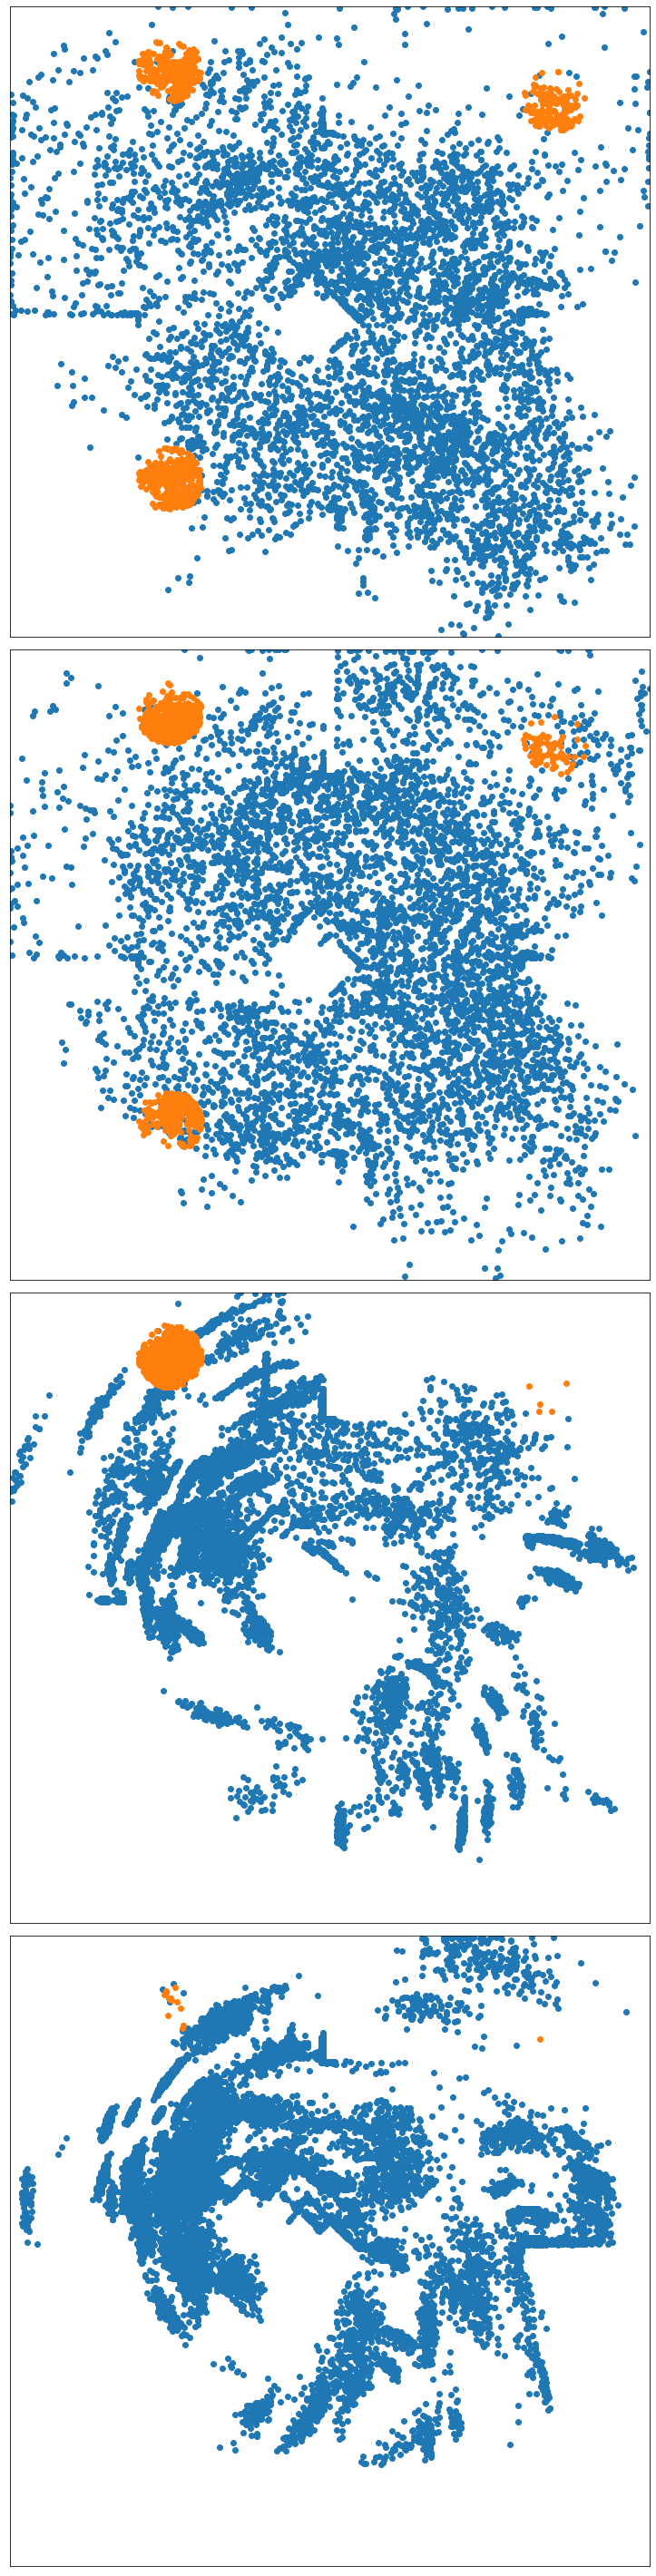

In [6]:
from matplotlib.patches import Rectangle

fig, axes = plt.subplots(len(exp_types), 1, figsize=(10, len(exp_types)*10))
fig.patch.set_facecolor('white')

axes = [axes]
if len(exp_types) == 1:
    axes = np.swapaxes([axes], 0, 1)
    
for exp_idx, exp in enumerate(exp_types):
    print("Working on exp: {}".format(exp))
    name = exp#.split('_')[0]
    
    archive = final_gt_bd[exp][best_run[exp]]['archive']
    rew_archive = final_gt_bd[exp][best_run[exp]]['rew archive']

    axes[0][exp_idx].scatter(archive[:, 0], archive[:, 1])
    if len(rew_archive)> 0:
        axes[0][exp_idx].scatter(rew_archive[:, 0], rew_archive[:, 1])
    
    axes[0][exp_idx].set_xticks(ticks=[]);
    axes[0][exp_idx].set_yticks(ticks=[]);
    axes[0][exp_idx].set_xlim(grid_parameters['min_coord'][0], grid_parameters['max_coord'][0]);
    axes[0][exp_idx].set_ylim(grid_parameters['min_coord'][1], grid_parameters['max_coord'][1]);
#     axes[0][exp_idx].set_title('{} BD'.format(name), fontsize=22);
    
plt.tight_layout()
plt.subplots_adjust(wspace=.05, left=0.01, bottom=0.01, right=0.99, top=0.99)
with open(os.path.join(save_path, 'archive_points.png'), 'wb') as f:
    plt.savefig(f, format='png');
plt.show();   

## Plot CVG and REW

/home/giuseppe/src/cmans/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:69: UserWarning: FixedFormatter should only be used together with FixedLocator


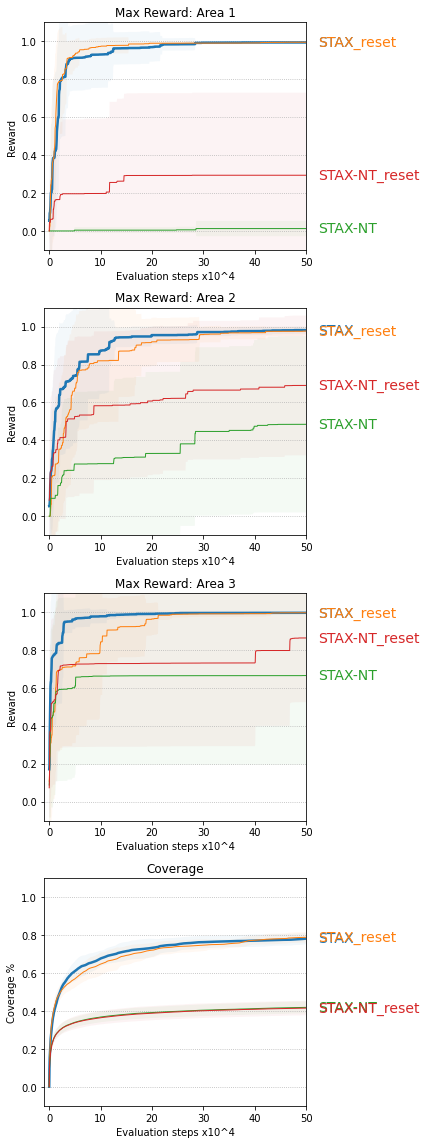

In [11]:
rew = {}
cvg = {}

areas = len(rew_eval[exp_types[0]][0])-1

fig, axes = plt.subplots(areas+1, 1, figsize=(6, 5*areas+1))
fig.patch.set_facecolor('white')
names = []

for exp_idx, exp in enumerate(exp_types):
    linewidth = 1
    name = exp#.split('_')[0]
    if name == 'FitNS': 
        name = 'SERENE'
#         linewidth = 2.5
    if name =='STAX-P': 
        linewidth = 2.5
        name = 'STAX'
        
    if name == 'STAX-P_multi':
        name = 'STAX'
        linewidth = 2.5
    if name == 'STAX-P_multi_reset':
        name = 'STAX_reset'
    if name == 'STAX-NT_multi': name = 'STAX-NT'
    if name == 'STAX-NT_multi_reset': name = 'STAX-NT_reset'
    
    names.append(name)    
    
    # Reward
    # ----------------------------------------------------
    rew[exp] = {i: [] for i in range(areas)}  
    
    for run in rew_eval[exp]:
        # Reformat reward data as {exp: {area: [runs]}}
        for idx, r_area in enumerate(run):
            if r_area != 'eval':
                rew[exp][idx].append(run[r_area])
            else:
                x_points = run['eval']
                
    for idx in range(areas):
        r_mean = np.mean(rew[exp][idx], axis=0)
        r_std = np.std(rew[exp][idx], axis=0)

        axes[idx].plot(x_points, r_mean, linewidth=linewidth)
        axes[idx].fill_between(x_points, r_mean-r_std, r_mean+r_std, alpha=0.05)
        
        axes[idx].set_title('Max Reward: Area {}'.format(idx+1))
        axes[idx].set_xlabel('Evaluation steps x10^4')
        axes[idx].set_ylabel('Reward')
    # ----------------------------------------------------
    
    # Coverage
    # ----------------------------------------------------
    cvg_mean = np.mean(cvgs[exp], axis=0)
    cvg_std = np.std(cvgs[exp], axis=0)
    axes[-1].plot(x_points, cvg_mean, linewidth=linewidth)
    axes[-1].fill_between(x_points, cvg_mean-cvg_std, cvg_mean+cvg_std, alpha=0.05)
        
    axes[-1].set_title('Coverage')
    axes[-1].set_xlabel('Evaluation steps x10^4')
    axes[-1].set_ylabel('Coverage %')
    # ----------------------------------------------------

for ax in axes:
    ax.set_xlim(-10000, 500000)
    xtickslocs = ax.get_xticks()
    ax.set_xticklabels(np.array(xtickslocs/10000, dtype=int))
    ax.set_ylim(-.1, 1.1)
    ax.grid(True, 'major', 'y', linestyle=':')
    
    
    for line, name in zip(ax.lines, names):
        y = line.get_ydata()[-1]
        ax.annotate(name, xy=(.97,y), xytext=(20,0), color=line.get_color(), 
                    xycoords = ax.get_yaxis_transform(), textcoords="offset points",
                    size=14, va="center", 
                   )
plt.tight_layout()
# plt.legend(names)
plt.savefig(os.path.join(save_path, 'perf_by_eval.pdf'), format='pdf')
plt.show();

## Plot Budget

In [9]:
params.evaluation_budget = 500000

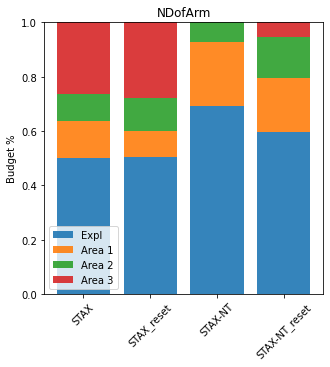

In [10]:
solutions = {}
areas = len(rew_eval[exp_types[0]][0])-1

# Extract focus data from recaps
# ----------------------------------------------------
for exp in exp_types:    
    solutions[exp] = {i: [] for i in range(areas)}
    for run in recaps[exp]:
        for idx in range(areas):
            try:
                solutions[exp][idx].append(run['rew_area_{}'.format(idx)])
            except:
                solutions[exp][idx].append(0)
# ----------------------------------------------------
                
# Plot
# ----------------------------------------------------
fig, axes = plt.subplots(1, 1, figsize=(5, 5))
fig.patch.set_facecolor('white')

data = []
for pos, exp in enumerate(exp_types):    
    data.append([np.mean(solutions[exp][i]) for i in range(areas)])
    data[-1].append(params.evaluation_budget - np.sum(data[-1]))

data = np.transpose(np.array(data))[::-1]/params.evaluation_budget
labels = ['Expl']
bar = []

for idx, dd in enumerate(data):
    if idx == 0:
        bottom = np.zeros_like(dd)
    else:
        bottom += data[idx-1]
        labels.append('Area {}'.format(idx))
    bar.append(axes.bar(range(len(exp_types)), dd, bottom=bottom, linewidth=0, alpha=.9))    
    
axes.set_ylim(0, 1)
axes.set_xticks(np.array(range(len(exp_types))))
axes.set_xticklabels(names, rotation=45)
axes.set_title(env);
axes.set_ylabel('Budget %')
axes.legend(bar, labels);
axes.legend(bar, labels, loc="lower left");

with open(os.path.join(save_path, 'area_perf.svg'), 'w') as f:
    plt.savefig(f, format='svg')
plt.show()
# ----------------------------------------------------
